Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization

%matplotlib inline

Extract data and train and test dataset

In [2]:
cifar100 = tf.keras.datasets.cifar100
(X_train,Y_train) , (X_test,Y_test) = cifar100.load_data()

169001437/169001437 [==============================] - 13s 0us/step


In [24]:
classes = ['beaver', 'dolphin', 'otter', 'seal', 'whale','aquarium_fish', 'flatfish', 'ray', 'shark', 'trout','orchid', 'poppy', 'rose', 'sunflower', 'tulip',
                 'bottle', 'bowl', 'can', 'cup', 'plate', 
                 'apple', 'mushroom', 'orange', 'pear', 'sweet_pepper',
                 'clock', 'keyboard', 'lamp', 'telephone', 'television',
                 'bed', 'chair', 'couch', 'table', 'wardrobe',
                 'bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach',
                 'bear', 'leopard', 'lion', 'tiger', 'wolf', 
                 'bridge', 'castle', 'house', 'road', 'skyscraper',
                'cloud', 'forest', 'mountain', 'plain', 'sea',
                 'camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo',
                 'fox', 'porcupine', 'possum', 'raccoon', 'skunk',
                 'crab', 'lobster', 'snail', 'spider', 'worm',
                 'baby', 'boy', 'girl', 'man', 'woman',
                 'crocodile', 'dinosaur', 'lizard', 'snake', 'turtle',
                 'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel',
                 'maple_tree', 'oak_tree', 'palm_tree', 'pine_tree', 'willow_tree',
                 'bicycle', 'bus', 'motorcycle', 'pickup_truck', 'train',
                 'lawn_mower', 'rocket', 'streetcar', 'tank', 'tractor']

In [25]:
len(classes)

100

Let's look into the dataset images

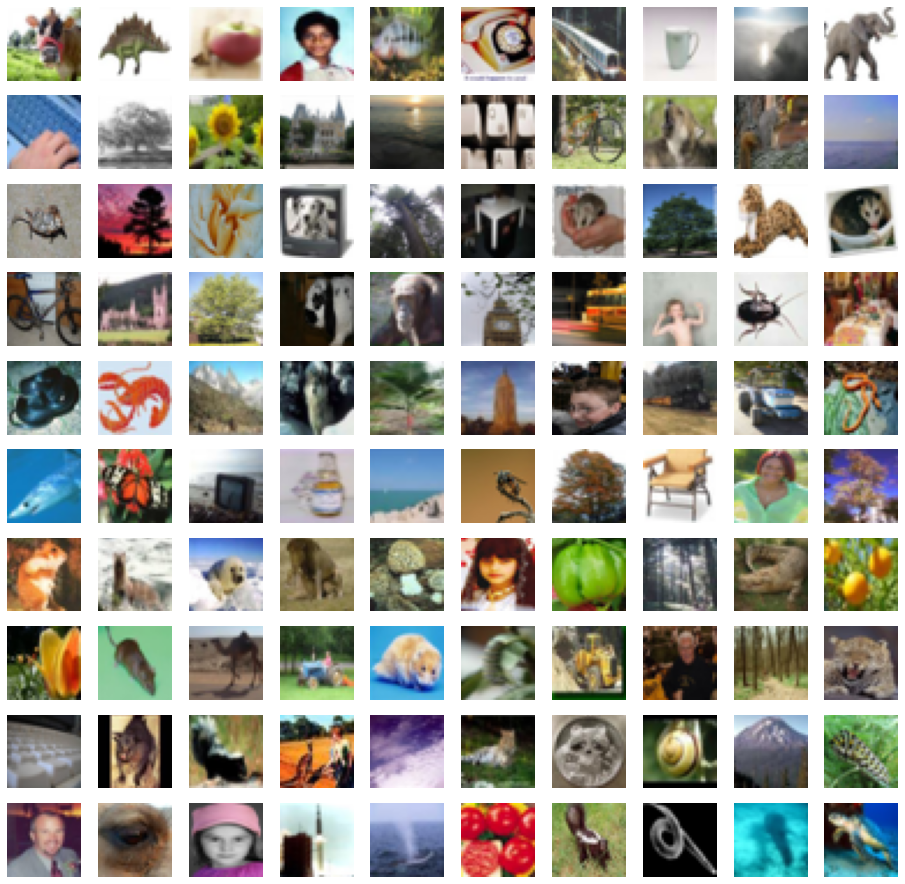

In [4]:
plt.figure(figsize = (16,16))
for i in range(100):
  plt.subplot(10,10,1+i)
  plt.axis('off')
  plt.imshow(X_train[i], cmap = 'gray')

Training , Validating and Splitting trained and tested data

In [5]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X_train,Y_train,test_size=0.2)

In [6]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, num_classes = 100)
y_val = to_categorical(y_val, num_classes = 100)

In [7]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(X_test.shape)
print(Y_test.shape)

(40000, 32, 32, 3)
(40000, 100)
(10000, 32, 32, 3)
(10000, 100)
(10000, 32, 32, 3)
(10000, 1)


In [8]:
train_datagen = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.vgg19.preprocess_input,
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    horizontal_flip = True
)
train_datagen.fit(x_train)

val_datagen = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg19.preprocess_input)
val_datagen.fit(x_val)

In [9]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

We have used only 16 layers out of 19 layers in the CNN

In [10]:
vgg_model = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=(32,32,3),
)

vgg_model.summary()

80134624/80134624 [==============================] - 6s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                              

In [11]:
model = tf.keras.Sequential()
model.add(vgg_model)
model.add(Flatten())
model.add(Dense(1024, activation = 'relu'))
model.add(Dense(1024, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(100, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_2 (Dense)             (None, 256)               262400    
                                                                 
 dense_3 (Dense)             (None, 100)               25700     
                                                                 
Total params: 21,887,396
Trainable params: 21,887,396
No

In [12]:
optimizer = tf.keras.optimizers.SGD(lr = 0.001, momentum = 0.9)
model.compile(optimizer= optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [13]:
history = model.fit(
    train_datagen.flow(x_train, y_train, batch_size = 128),
    validation_data = val_datagen.flow(x_val,y_val, batch_size = 128),
    epochs = 25,
    verbose = 1,
    callbacks = [learning_rate_reduction]
)

Epoch 1/25
313/313 [==============================] - 46s 113ms/step - loss: 4.5756 - accuracy: 0.0148 - val_loss: 4.4736 - val_accuracy: 0.0174 - lr: 0.0010
Epoch 2/25
313/313 [==============================] - 34s 108ms/step - loss: 4.4350 - accuracy: 0.0238 - val_loss: 4.3916 - val_accuracy: 0.0313 - lr: 0.0010
Epoch 3/25
313/313 [==============================] - 34s 108ms/step - loss: 4.2633 - accuracy: 0.0437 - val_loss: 4.1109 - val_accuracy: 0.0623 - lr: 0.0010
Epoch 4/25
313/313 [==============================] - 37s 117ms/step - loss: 3.9797 - accuracy: 0.0728 - val_loss: 3.5971 - val_accuracy: 0.1235 - lr: 0.0010
Epoch 5/25
313/313 [==============================] - 34s 108ms/step - loss: 3.2327 - accuracy: 0.1824 - val_loss: 2.9269 - val_accuracy: 0.2460 - lr: 0.0010
Epoch 6/25
313/313 [==============================] - 34s 108ms/step - loss: 2.6477 - accuracy: 0.3053 - val_loss: 2.4715 - val_accuracy: 0.3459 - lr: 0.0010
Epoch 7/25
313/313 [==============================] 

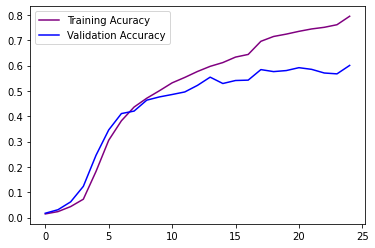

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure()
plt.plot(acc,color = 'purple',label = 'Training Acuracy')
plt.plot(val_acc,color = 'blue',label = 'Validation Accuracy')
plt.legend()

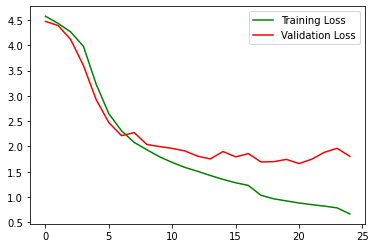

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(loss,color = 'green',label = 'Training Loss')
plt.plot(val_loss,color = 'red',label = 'Validation Loss')
plt.legend()

In [18]:
x_test = tf.keras.applications.vgg19.preprocess_input(X_test)
y_pred = np.argmax(model.predict(x_test), axis=-1)
y_pred[:10]

313/313 [==============================] - 4s 10ms/step


array([68, 33, 38, 93, 71,  6, 56, 75, 71,  0])

In [19]:
from sklearn.metrics import confusion_matrix, accuracy_score
print('Testing Accuarcy : ', accuracy_score(Y_test, y_pred))

Testing Accuarcy :  0.6005


In [20]:
cm = confusion_matrix(Y_test, y_pred)
cm

array([[79,  0,  0, ...,  0,  0,  0],
       [ 0, 67,  1, ...,  0,  0,  0],
       [ 0,  0, 50, ...,  0,  6,  0],
       ...,
       [ 0,  0,  0, ..., 59,  0,  1],
       [ 0,  0,  8, ...,  0, 31,  0],
       [ 0,  0,  0, ...,  0,  1, 74]])

In [26]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=30)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


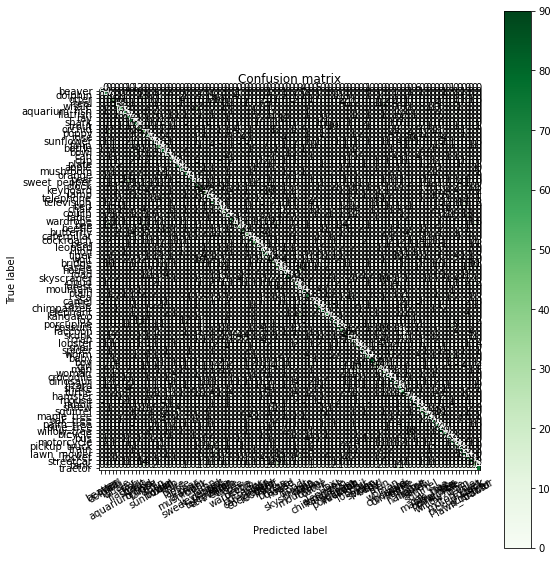

In [27]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm,classes)